In [1]:
!nvidia-smi

Wed Mar 12 08:48:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:31:00.0 Off |                    0 |
| N/A   39C    P8             16W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    # Set default CUDA device
    torch.cuda.set_device(0)
    # Display memory information
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
else:
    print("CUDA is not available. Training will use CPU only.")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA L4
CUDA version: 12.1
Total GPU memory: 23.57 GB
Allocated GPU memory: 0.00 GB
Reserved GPU memory: 0.00 GB


In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/ubuntu/projects/sure-football-analysis


In [4]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/home/ubuntu/projects/sure-football-analysis/segment-anything-2
^C
ERROR: Operation cancelled by user
CUDA_HOME environment variable is not set. Please set it to your CUDA install root.

Failed to build the SAM 2 CUDA extension due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; (see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).

running build_ext
/home/ubuntu/miniconda3/envs/football/lib/python3.11/site-packages/torch/utils/cpp_extension.py:497: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))


In [4]:
!pip install -q supervision[assets] jupyter_bbox_widget

### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/app/models/sam_models/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/app/models/sam_models/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/app/models/sam_models/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/app/models/sam_models/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/app/models/sam_models/checkpoints

In [5]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


In [7]:
if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

## Load Model

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/app/models/sam_models/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT, device=device)

In [9]:
# SOURCE_VIDEO = download_assets(VideoAssets.BASKETBALL)
SOURCE_VIDEO =  f"{HOME}/0bfacc_0.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)

**NOTE:** To reduce VRAM requirements, three additional parameters: `SCALE_FACTOR` to decrease the frame resolution, and `START_IDX` and `END_IDX` to extract only the relevant segments from the video.

In [15]:
SCALE_FACTOR = 0.7
START_IDX = 100
END_IDX = 500

SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [24]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 400/400 [00:09<00:00, 41.88it/s]


In [ ]:
# sam2_model.reset_state(inference_state)

In [25]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [26]:
OBJECTS = ['ball', 'defender', 'attacker']

FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['ball', 'defender', 'attacker'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#946…

**NOTE:** The widget we are using stores annotations in a format that is inconsistent with SAM2's requirements. We parse them and then pass them to SAM2 via the `add_new_points` method. Each of the objects we track must be passed via a separate `add_new_points` call. It is important to specify `frame_idx` each time - the index of the frame to which the annotations relate, and `obj_id` - the ID of the object to which the annotations relate.

In [27]:
default_box = [
    {'x': 705, 'y': 302, 'width': 0, 'height': 0, 'label': 'ball'},
    {'x': 587, 'y': 300, 'width': 0, 'height': 0, 'label': 'defender'},
    {'x': 753, 'y': 267, 'width': 0, 'height': 0, 'label': 'attacker'},
]

boxes = widget.bboxes if widget.bboxes else default_box
print("Boxes:", boxes)

for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

Boxes: [{'x': 834, 'y': 557, 'width': 0, 'height': 0, 'label': 'ball'}, {'x': 856, 'y': 530, 'width': 0, 'height': 0, 'label': 'defender'}, {'x': 929, 'y': 419, 'width': 0, 'height': 0, 'label': 'attacker'}]


### Video inference

**NOTE:** To apply our point prompts to all video frames, we use the `propagate_in_video` generator. Each call returns `frame_idx` - the index of the current frame, `object_ids` - IDs of objects detected in the frame, and `mask_logits` - corresponding `object_ids` logit values, which we can convert to masks using thresholding.

In [32]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video:   0%|          | 2/400 [00:00<00:31, 12.78it/s]

propagate in video: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]


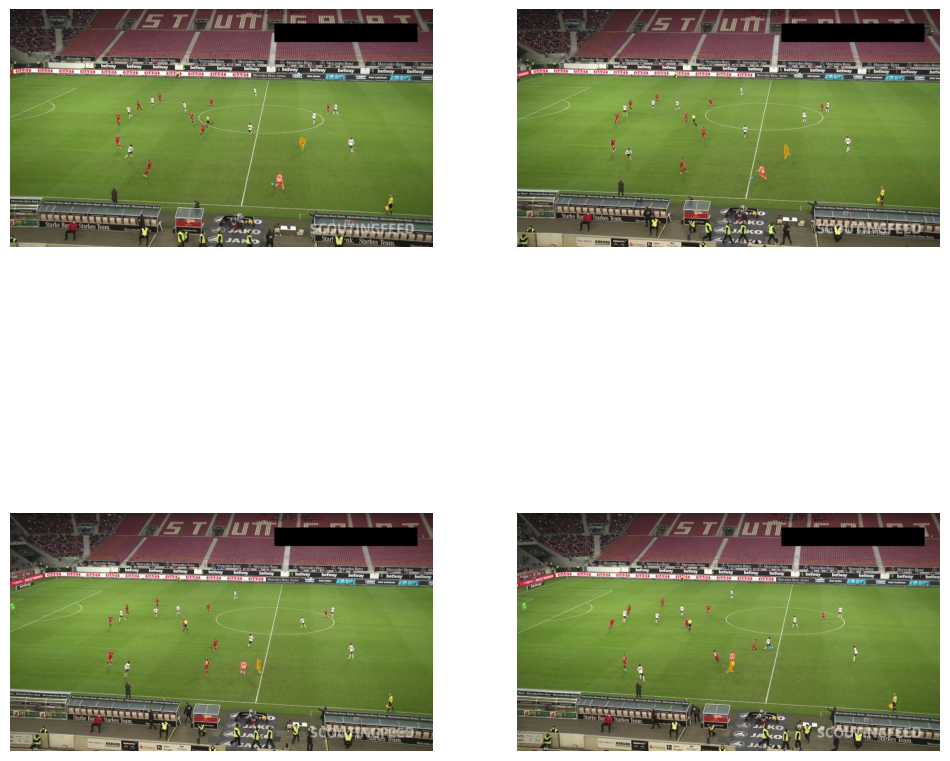

In [33]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)

In [31]:
from IPython.display import FileLink
import os
# from google.colab import files

# Get file path
result_video_path = TARGET_VIDEO

# Display file size
file_size_mb = os.path.getsize(result_video_path) / (1024 * 1024)
print(f"File size: {file_size_mb:.2f} MB")

# Create download link based on environment
if IS_COLAB:
    files.download(str(result_video_path))
    print("Download started. Check your browser's download folder.")
else:
    # For standard Jupyter notebook/lab
    print("Click the link below to download the result video:")
    display(FileLink(result_video_path, result_html_prefix="Download: "))

File size: 0.00 MB
Click the link below to download the result video:


/home/ubuntu/projects/sure-football-analysis/0bfacc_0-result.mp4

---
# Using 2 different YOLO models